In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [11]:
!pip install opendatasets

In [12]:
import opendatasets as od

# Download a dataset
dataset_url = 'https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml/data'
od.download(dataset_url)

Skipping, found downloaded files in "./synthetic-transaction-monitoring-dataset-aml" (use force=True to force download)


In [13]:
df = pd.read_csv("/content/synthetic-transaction-monitoring-dataset-aml/SAML-D.csv")
df = df.sample(n=100000, random_state=42)

In [14]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
42444,19:24:09,2022-10-08,6077900993,6609117934,2299.89,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Group
8169290,18:12:15,2023-07-08,5459041199,816242179,211.90,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
7894834,12:19:54,2023-06-29,4641798002,5214523833,9481.26,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4265755,11:35:53,2023-02-27,1475899462,6151077027,11609.92,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_Out
7437932,10:54:00,2023-06-14,8046287266,3423799664,17772.58,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In


<Axes: xlabel='Is_laundering', ylabel='count'>

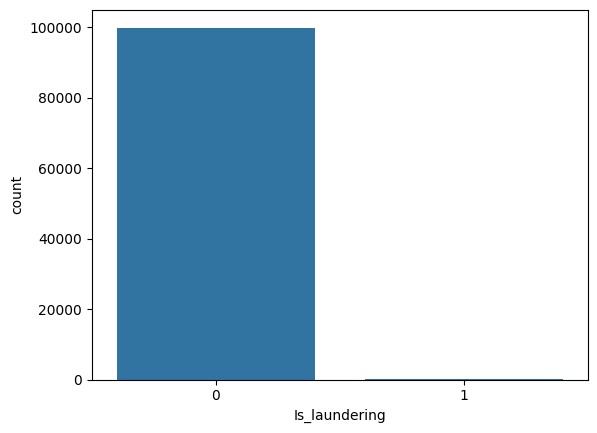

In [15]:
sns.countplot(data = df, x="Is_laundering")

In [32]:
df2 = df.copy()


df2['Date'] = pd.to_datetime(df2['Date'])

# Extract month, day, and week

df2['Year'] = pd.to_datetime(df2['Date']).dt.year
df2['Month'] = pd.to_datetime(df2['Date']).dt.month
df2['Day'] = pd.to_datetime(df2['Date']).dt.day
df2['Week'] = df2['Date'].dt.isocalendar().week

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 42444 to 7723883
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    100000 non-null  object        
 1   Date                    100000 non-null  datetime64[ns]
 2   Sender_account          100000 non-null  int64         
 3   Receiver_account        100000 non-null  int64         
 4   Amount                  100000 non-null  float64       
 5   Payment_currency        100000 non-null  object        
 6   Received_currency       100000 non-null  object        
 7   Sender_bank_location    100000 non-null  object        
 8   Receiver_bank_location  100000 non-null  object        
 9   Payment_type            100000 non-null  object        
 10  Is_laundering           100000 non-null  int64         
 11  Laundering_type         100000 non-null  object        
 12  Year                    100000

In [34]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type'],
      dtype='object')

<Axes: xlabel='Year', ylabel='count'>

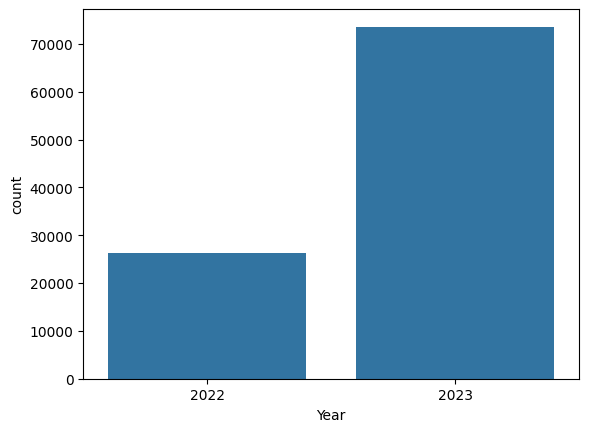

In [35]:
sns.countplot(data=df2, x='Year')

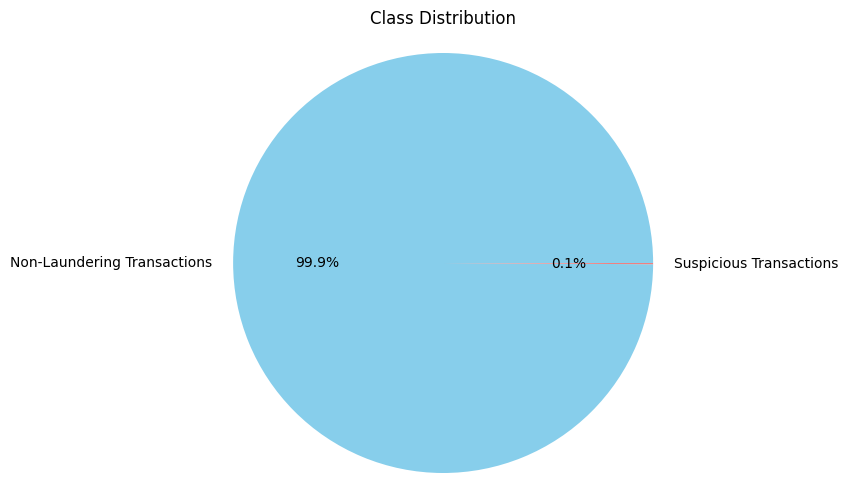

In [37]:
class_distribution = df2['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show();

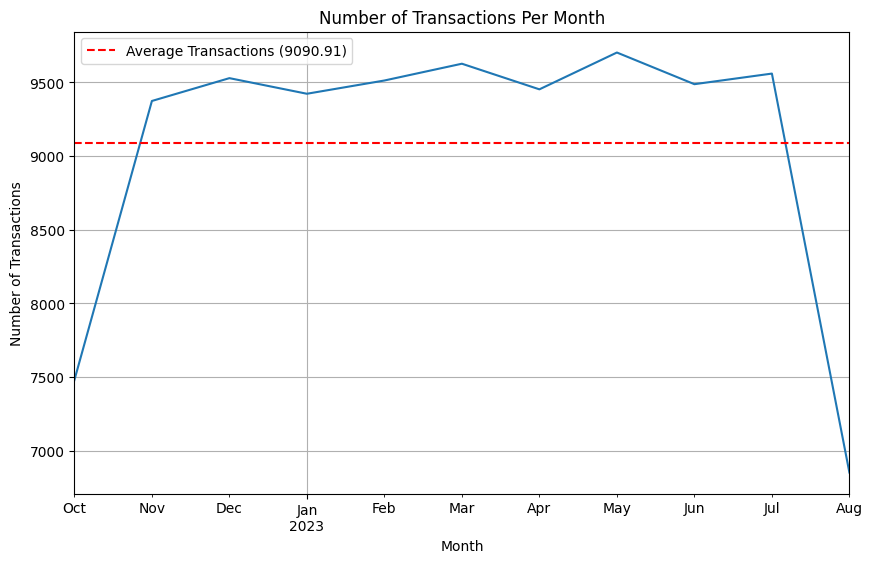

In [38]:
## Monthly Transactions

monthly_transactions = df.groupby(df['Date'].dt.to_period('M')).size()

average_monthly_transactions = monthly_transactions.mean()

plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line')
plt.axhline(y=average_monthly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_monthly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Month')
plt.legend()
plt.grid(True)
plt.show();

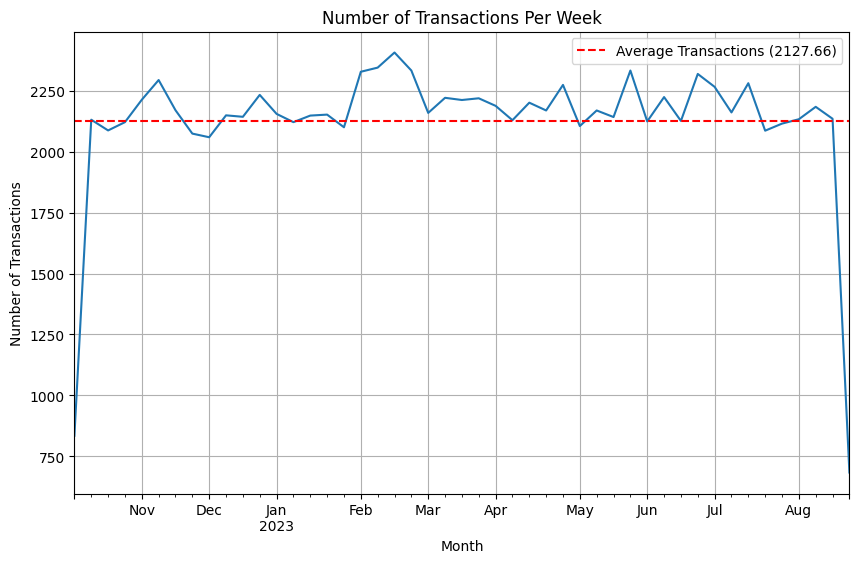

In [39]:
## Weekly Transactions

weekly_transactions = df.groupby(df['Date'].dt.to_period('W')).size()

average_weekly_transactions = weekly_transactions.mean()

plt.figure(figsize=(10, 6))
weekly_transactions.plot(kind='line')
plt.axhline(y=average_weekly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_weekly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Week')
plt.legend()
plt.grid(True)
plt.show();

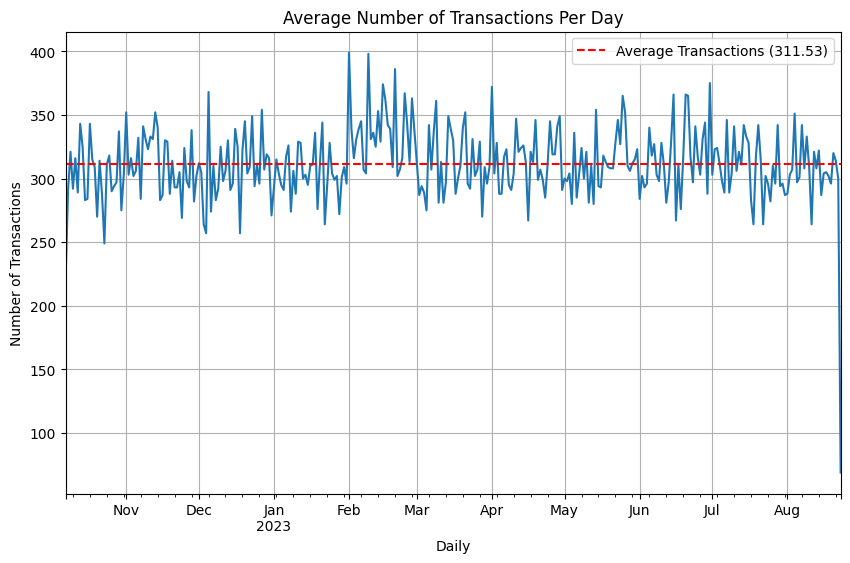

In [40]:
## Daily Transactions

daily_transactions = df.groupby(df['Date'].dt.to_period('D')).size()

average_daily_transactions = daily_transactions.mean()


plt.figure(figsize=(10, 6))
daily_transactions.plot(kind='line')
plt.axhline(y=average_daily_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_daily_transactions:.2f})')
plt.xlabel('Daily')
plt.ylabel('Number of Transactions')
plt.title('Average Number of Transactions Per Day')
plt.legend()
plt.grid(True)
plt.show();

In [41]:
df['Is_laundering'].value_counts()

,count
Is_laundering,
0,99905
1,95


Original Skewness: 29.85602388769141
Log-Transformed Skewness: -1.0085992227804599


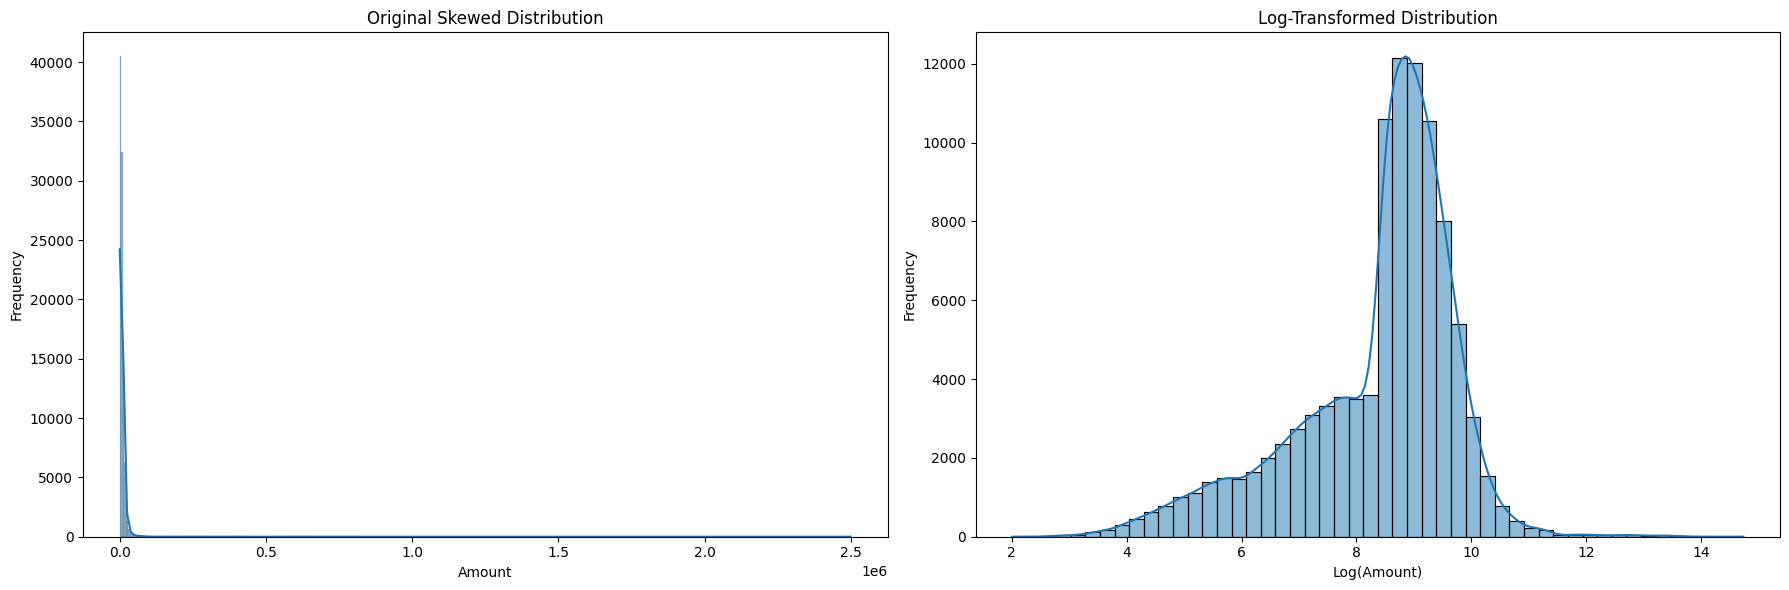

In [42]:
skewed_data = df['Amount']

original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

# Apply a log transformation
log_transformed_data = np.log1p(skewed_data)
# skewness after log transformation
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show();


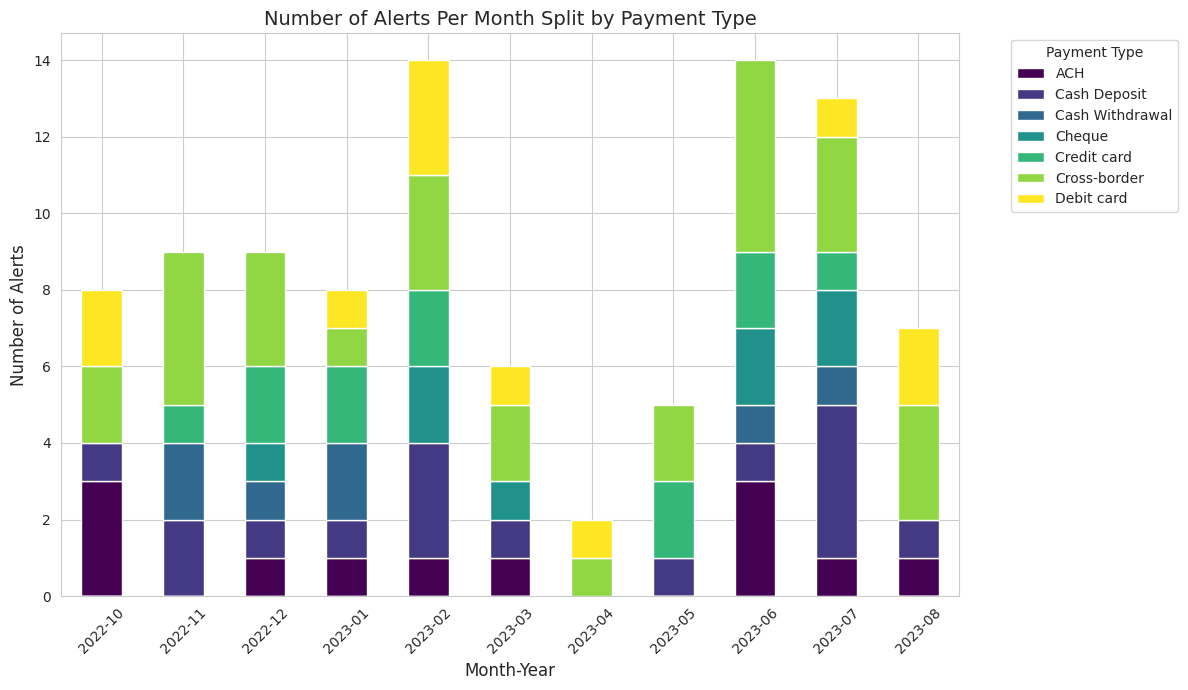

In [43]:
df['Date'] = pd.to_datetime(df['Date'])
grouped_data = df.groupby(['Date', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
grouped_data['Month_Year'] = grouped_data['Date'].dt.to_period('M')
monthly_alerts = grouped_data.groupby(['Month_Year', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()

pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', ax=ax, stacked=True, colormap='viridis')
pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

plt.title('Number of Alerts Per Month Split by Payment Type', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

In [16]:
train_start = '2022-10-01'
train_end = '2023-05-31'
test_start = '2023-06-01'
test_end = '2023-08-31'

# Split the data into training and test sets based on the 'Date' column
train_data = df[(df['Date'] >= train_start) & (df['Date'] <= train_end)]
test_data = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)]

In [17]:
train_data.drop(columns=['Laundering_type', 'Time', 'Date'], inplace=True)
test_data.drop(columns=['Laundering_type', 'Time', 'Date'], inplace=True)

In [18]:
from sklearn import preprocessing

In [19]:
test_data.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
8169290,5459041199,816242179,211.90,UK pounds,UK pounds,UK,UK,Cheque,0
7894834,4641798002,5214523833,9481.26,UK pounds,UK pounds,UK,UK,ACH,0
7437932,8046287266,3423799664,17772.58,UK pounds,UK pounds,UK,UK,ACH,0
8064964,4097215471,9308332143,2101.29,UK pounds,UK pounds,UK,UK,Debit card,0
8393487,3851728451,5658201442,2397.06,Moroccan dirham,Pakistani rupee,UK,Pakistan,Cross-border,0


In [20]:
from sklearn import preprocessing

categorical_cols = ['Sender_account', 'Receiver_account', 'Payment_currency', 'Received_currency',
                   'Sender_bank_location', 'Receiver_bank_location', 'Payment_type']

# Concatenate train and test to fit encoders
full_data = pd.concat([train_data, test_data], axis=0)

for col in categorical_cols:
    encoder = preprocessing.LabelEncoder()
    encoder.fit(full_data[col])  # Fit on combined data
    train_data[col] = encoder.transform(train_data[col])
    test_data[col] = encoder.transform(test_data[col])

# Scaling numeric columns
numerical_cols = ['Amount']
scaler = preprocessing.StandardScaler()
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

In [21]:
# Check the shape of training and test data
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)

Shape of train_data: (74101, 9)
Shape of test_data: (25899, 9)


In [22]:
# Define the target variable
target_col = 'Is_laundering'

# Separate features and target for training and test sets
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]
X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

# Display the shapes to confirm the split
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (74101, 8)
Shape of y_train: (74101,)
Shape of X_test: (25899, 8)
Shape of y_test: (25899,)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the shape after resampling
print("Shape of X_train after SMOTE:", X_train_resampled.shape)
print("Shape of y_train after SMOTE:", y_train_resampled.shape)

Shape of X_train after SMOTE: (148080, 8)
Shape of y_train after SMOTE: (148080,)


In [24]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Create the model
hgb_classifier = HistGradientBoostingClassifier(
    max_iter=100,                # Maximum number of boosting iterations
    learning_rate=0.1,           # Step size in each iteration
    max_depth=5,                 # Maximum depth of each tree
    random_state=42,
)

# Train the model
hgb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = hgb_classifier.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9709641298891849
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     25865
           1       0.01      0.29      0.03        34

    accuracy                           0.97     25899
   macro avg       0.51      0.63      0.51     25899
weighted avg       1.00      0.97      0.98     25899

Confusion Matrix:
[[25137   728]
 [   24    10]]


In [25]:
import pickle

# Assuming your model is stored in hgb_classifier
filename = 'hgb_classifier_model.pkl'

# Save the model using pickle
with open(filename, 'wb') as file:
    pickle.dump(hgb_classifier, file)


In [26]:
# Load the saved model
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Now you can use the loaded model to make predictions
y_pred = loaded_model.predict(X_test)

In [45]:
X_test.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type
8169290,25015,6352,-0.355872,10,10,16,16,3
7894834,21261,41052,0.025353,10,10,16,16,0
7437932,36623,27012,0.366353,10,10,16,16,0
8064964,18797,72714,-0.278167,10,10,16,16,6
8393487,17643,44370,-0.266002,5,7,16,11,5


In [47]:
# Assuming your new data is stored in 'new_data'
new_data = pd.DataFrame({
    'Sender_account': ['Account_1'],
    'Receiver_account': ['Account_2'],
    'Amount': [5000],
    'Payment_currency': ['UK pounds'],
    'Received_currency': ['Pakistani rupee'],
    'Sender_bank_location': ['UK'],
    'Receiver_bank_location': ['Pakistan'],
    'Payment_type': ['Cross-border']

})

# Preprocess the new data

# Handle categorical columns
for col in categorical_cols:
    # If there are unseen labels, map them to the default category or use the encoder
    if col in new_data.columns:
        new_data[col] = new_data[col].apply(lambda x: x if x in encoder.classes_ else encoder.classes_[0])
        new_data[col] = encoder.transform(new_data[col])

# Scale the numerical columns (e.g., 'Amount')
new_data[numerical_cols] = scaler.transform(new_data[numerical_cols])

# Make predictions
new_predictions = hgb_classifier.predict(new_data)

# Output predictions
print("Predictions on new data:", new_predictions)


Predictions on new data: [0]
